### Tutorial on Keras with Gensim
https://www.depends-on-the-definition.com/guide-to-word-vectors-with-gensim-and-keras/

- http://www.orbifold.net/default/2017/01/10/embedding-and-tokenizer-in-keras/
- https://github.com/keras-team/keras/issues/853
- http://adventuresinmachinelearning.com/gensim-word2vec-tutorial/
- https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
- https://stats.stackexchange.com/questions/320701/how-to-use-keras-pre-trained-embedding-layer
- https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
- https://codekansas.github.io/blog/2016/gensim.html

In [1]:
% load_ext autoreload
% autoreload 2

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from nltk.tokenize import WordPunctTokenizer
from collections import Counter

from keras.layers import Dense, Input, LSTM, CuDNNLSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
%matplotlib inline

import utils
import text_utils

c:\users\thomas\python\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\thomas\hpi\textmi~1\venv\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Constants

OUTPUT_DIR = './week-7-plots'

SRC_ENHANCED_COMMENTS = '../data/pol/comments-root-all-pol-enhanced.csv'

SRC_GENSIM_EMBEDDING = '../data/embedding/gensim-guardian-comments-50-tokenized.bin'

#### Load embedding

In [3]:
word_vectors = text_utils.load_embedding()
index2word = word_vectors.index2word  # Map index to word
word2index = dict((x, y) for y,x in enumerate(word_vectors.index2word))  # Map word to index

print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Loading embeddings...
Number of word vectors: 1286151


In [4]:
word_vectors.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

[('queen', 0.9264782071113586),
 ('regnant', 0.901670515537262),
 ('king/queen', 0.8998395800590515),
 ('monarhy', 0.8881024718284607),
 ('royal', 0.8818458914756775),
 ('regent', 0.8790533542633057),
 ('virgina', 0.8765912652015686),
 ('monarch', 0.8760467171669006),
 ('empress', 0.8739269375801086),
 ('prince', 0.8708903789520264)]

#### Preprocess data

In [5]:
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH = 300

comments = pd.read_csv(SRC_ENHANCED_COMMENTS)
X = comments['comment_text']
y = to_categorical(comments['bin'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# Pad/Cut tokenized comments to a certain length
X_train, X_test = text_utils.pad_or_cut_tokenized_comments(X_train, X_test, word2index, MAX_SEQUENCE_LENGTH)

Shape of training data tensor: (64000, 300)
Shape of test_data tensor: (16000, 300)


#### Prepare Keras Model

In [14]:
model = Sequential()
model.add(Embedding(len(word_vectors.vocab),
                    EMBEDDING_DIM,
                    mask_zero=False,
                    weights=[word_vectors.syn0],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(SpatialDropout1D(0.1))
# model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.3, dropout=0.3))
model.add(LSTM(32, recurrent_dropout=0, dropout=0.1))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['binary_accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 50)           64307550  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 300, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 64,318,240
Trainable params: 10,690
Non-trainable params: 64,307,550
_________________________________________________________________


In [16]:
epochs = 10
batch_size = 32

# Here we train the Network.
try:
    history = model.fit([X_train], y_train, validation_split=0.1,
                        batch_size = batch_size, epochs = epochs,
                        verbose = 2, shuffle=True)
except KeyboardInterrupt:
    print("Fitting stopped manually")

Train on 57600 samples, validate on 6400 samples
Epoch 1/10
 - 528s - loss: 0.6925 - binary_accuracy: 0.5189 - val_loss: 0.6932 - val_binary_accuracy: 0.5209
Epoch 2/10
 - 349s - loss: 0.6908 - binary_accuracy: 0.5255 - val_loss: 0.6899 - val_binary_accuracy: 0.5288
Epoch 3/10
 - 339s - loss: 0.6905 - binary_accuracy: 0.5277 - val_loss: 0.6903 - val_binary_accuracy: 0.5328
Epoch 4/10
 - 340s - loss: 0.6901 - binary_accuracy: 0.5306 - val_loss: 0.6911 - val_binary_accuracy: 0.5309
Epoch 5/10
 - 338s - loss: 0.6901 - binary_accuracy: 0.5296 - val_loss: 0.6910 - val_binary_accuracy: 0.5284
Epoch 6/10
 - 1477s - loss: 0.6867 - binary_accuracy: 0.5480 - val_loss: 0.6840 - val_binary_accuracy: 0.5656
Epoch 7/10
Fitting stopped manually


In [12]:
text_utils.inspect_preprocessed_comment(comments, X_train, index2word, 0)

Original:
Unnamed: 0                                                  1286917
Unnamed: 0.1                                               57663830
article_id                                                   578659
author_id                                                    333013
comment_id                                                 40702885
comment_text      I’ve not really been payng too close attention...
timestamp                                      2014-09-11T10:55:37Z
upvotes                                                           9
rank                                                              1
total_upvotes                                                    11
total_comments                                                   13
rel_upvotes                                                 81.8182
bin                                                               1
Name: 0, dtype: object

After preprocessing (& backtranslating):



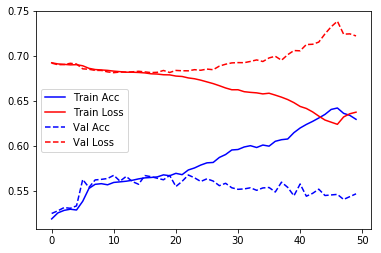

In [9]:
utils.plot_history(history)

In [11]:
# Measuring score and accuracy on test set

score, acc = model.evaluate([X_test], y_test, verbose = 2,
                            batch_size = batch_size)
print("Logloss score: %.2f" % (score))
print("Test set Accuracy: %.2f" % (acc))

Logloss score: 0.73
Test set Accuracy: 0.54


In [13]:
plt.hist(comments['comment_text'].str.split().len)

AttributeError: 'Series' object has no attribute 'len'